In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



# 1. Load and Parse captions

In [3]:
import os
from collections import defaultdict

captions_path = "/kaggle/input/flickr8k/captions.txt"
images_path = "/kaggle/input/flickr8k/Images/"

def load_captions(filepath):
    captions_dict = defaultdict(list)
    with open(filepath, 'r') as f:
        next(f)  # skip header
        for line in f:
            img_id, caption = line.strip().split(',', 1)
            img_id = img_id.strip()
            caption = caption.strip()
            captions_dict[img_id].append(f"<start> {caption} <end>")
    return captions_dict

captions_dict = load_captions(captions_path)
print(f"Loaded {len(captions_dict)} images with captions")


Loaded 8091 images with captions


# 2. Preprocess Images + Extract Features with InceptionV3

In [4]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import tqdm

# Build feature extractor
def build_feature_extractor():
    model = InceptionV3(weights="imagenet")
    model_new = Model(model.input, model.get_layer("avg_pool").output)
    return model_new

model_cnn = build_feature_extractor()

# Process and extract features
def extract_features(img_folder, captions_dict):
    features = dict()
    for img_name in tqdm.tqdm(captions_dict.keys()):
        path = os.path.join(img_folder, img_name)
        img = load_img(path, target_size=(299, 299))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = model_cnn.predict(img, verbose=0)
        features[img_name] = feature.flatten()
    return features

features = extract_features(images_path, captions_dict)

# Save for reuse
np.save("features.npy", features)


2025-07-03 08:43:54.913545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751532235.108762      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751532235.164262      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751532247.925628      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751532247.926286      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1751532255.191698     104 service.cc:148] XLA service 0x7ca3bc004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751532255.192492     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751532255.192514     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751532256.150414     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751532260.700127     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [13:32<00:00,  9.96it/s]


# 3.Tokenizer and Caption Sequences

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Flatten all captions
all_captions = []
for cap_list in captions_dict.values():
    all_captions.extend(cap_list)

# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [32]:
max_length

40

# Step 4.Create a Generator with Batching

In [11]:
def data_generator(captions_dict, features, tokenizer, max_length, vocab_size, batch_size):
    img_names = list(captions_dict.keys())
    while True:
        np.random.shuffle(img_names)
        for i in range(0, len(img_names), batch_size):
            X1, X2, y = [], [], []
            for img_name in img_names[i:i+batch_size]:
                feature = features[img_name]
                for cap in captions_dict[img_name]:
                    seq = tokenizer.texts_to_sequences([cap])[0]
                    for j in range(1, len(seq)):
                        in_seq, out_seq = seq[:j], seq[j]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical(out_seq, num_classes=vocab_size)
                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)
            yield ((np.array(X1), np.array(X2)), np.array(y))


#  5. Define the Image Captioning Model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

def build_model(vocab_size, max_length):
    # Image features
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Captions
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256)(inputs2)

    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, use_cudnn=False)(se2)


    # Decoder (merge)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = build_model(vocab_size, max_length)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 40, 256)        │      2,174,720 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 2048)           │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 40, 256)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        524,544 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ dense_6[0][0],         │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │         65,792 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8495)           │      2,183,215 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,473,583 (20.88 MB)

 Trainable params: 5,473,583 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

# ✅  6. Train the Model 

In [15]:
batch_size = 64
steps = len(captions_dict) // batch_size

generator = data_generator(captions_dict, features, tokenizer, max_length, vocab_size, batch_size)

model.fit(generator, epochs=20, steps_per_epoch=steps)



# Save the model
model.save("image_caption_model.h5")


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - loss: 5.8011
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - loss: 3.8876
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - loss: 3.3956
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 3.1380
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 2.9925
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 2.8813
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 119s 950ms/step - loss: 2.7946
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 112s 894ms/step - loss: 2.7023
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 120s 952ms/step - loss: 2.6417
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 659ms/step - loss: 2.5850
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 113s 898ms/step - loss: 2.5335
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 94s 745ms/step - loss: 2.4732
Epoch 13/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 660ms/step - loss: 2.4363
Epoch 14/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 661ms/step - loss: 2.3956
Epoch 15/20
126/126 ━━━

In [16]:
with open("max_length.pkl", "wb") as f:
    pickle.dump(max_length, f)

# 7.Image Captioning Model Inference 

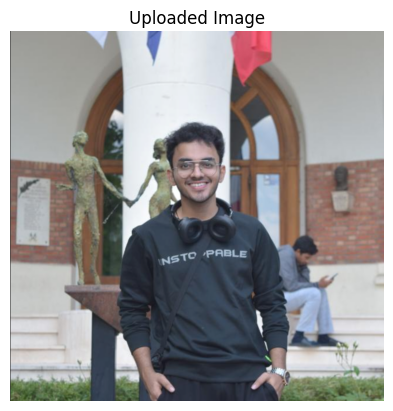

Generated Caption: men in front of a blue building end of a brick wall end end


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ========== CONFIG ==========
CAPTION_MODEL_PATH = '/kaggle/working/image_caption_model.h5'
TOKENIZER_PATH = '/kaggle/working/tokenizer.pkl'
IMAGE_PATH = '/kaggle/input/image07/image07.png'
MAX_LENGTH = 40
IMAGE_SIZE = (299, 299)  # For InceptionV3
# ============================

# Load tokenizer
with open(TOKENIZER_PATH, 'rb') as f:
    tokenizer = pickle.load(f)

# Load trained caption model
caption_model = load_model(CAPTION_MODEL_PATH)

# Load CNN (InceptionV3) for feature extraction
def build_feature_extractor():
    base_model = InceptionV3(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)  # output is (2048,)
    return model

cnn_model = build_feature_extractor()

# Preprocess image and extract 2048D feature
def extract_features(image_path, cnn_model):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = cnn_model.predict(img, verbose=0)
    return features

# Generate caption using greedy decoding
def generate_caption(image_path, caption_model, cnn_model, tokenizer, max_length=MAX_LENGTH):
    photo = extract_features(image_path, cnn_model)
    caption = ['<start>']

    for _ in range(15):
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq = pad_sequences([seq], maxlen=max_length)

        yhat = caption_model.predict([photo, seq], verbose=0)
        yhat = np.argmax(yhat)
        
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        caption.append(word)
        if word == '<end>':
            break

    final_caption = ' '.join(caption[1:-1])  # remove <start> and <end>
    return final_caption

# Show image (optional)
img = load_img(IMAGE_PATH)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# Generate and display caption
caption = generate_caption(IMAGE_PATH, caption_model, cnn_model, tokenizer)
print("Generated Caption:", caption)
